In [1]:
# Import packages
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

In [3]:
import os
import dill, sys
import copy
import numpy as np
import matplotlib.pyplot as plt
import scarlet

import statmorph

import kuaizi as kz
from kuaizi.display import display_single, SEG_CMAP, display_scarlet_results_tigress
from kuaizi.detection import Data


import astropy.units as u
from astropy import wcs
from astropy.io import fits
from astropy.table import Table, Column, Row

In [4]:
env_dict = {'project': 'HSC', 'name': 'LSBG', 'data_dir': '/scratch/gpfs/jiaxuanl/Data'}
kz.utils.set_env(**env_dict)

'/scratch/gpfs/jiaxuanl/Data/HSC/LSBG'

In [116]:
lsbg_cat = Table.read('./Catalog/NSA/z002_004/nsa_cutout_cat_z002_004.fits')
lsbg_cat.sort('viz-id')

### The measurement is done by running `sbatch 1k_meas.slurm`, etc. Check `vanilla_measure_all.py` for details.

The measurement catalogs are saved at `./Catalog/NSA/z002_004/lsbg_measure_vaniila_XXXXX.fits`.

Below, we combine these catalogs together.

In [18]:
meas_cat_all = Table.read('./Catalog/NSA/z002_004/lsbg_measure_vanilla_0_500.fits')
meas_cat_all[500:1000] = Table.read('./Catalog/NSA/z002_004/lsbg_measure_vanilla_500_1000.fits')[500:1000]
meas_cat_all[1000:2000] = Table.read('./Catalog/NSA/z002_004/lsbg_measure_vanilla_2k.fits')[1000:2000]
meas_cat_all[2000:3000] = Table.read('./Catalog/NSA/z002_004/lsbg_measure_vanilla_3k.fits')[2000:3000]
meas_cat_all[3000:4000] = Table.read('./Catalog/NSA/z002_004/lsbg_measure_vanilla_4k.fits')[3000:4000]
meas_cat_all[4000:] = Table.read('./Catalog/NSA/z002_004/lsbg_measure_vanilla_5k.fits')[4000:]

In [19]:
meas_cat_all

ID,flux [4],mag [4],SB_0 [4],SB_eff_circ [4],SB_eff_ellip [4],xc_cen,yc_cen,xc_sym,yc_sym,ell_cen,ell_sym,PA_cen,PA_sym,rhalf_circ,rhalf_ellip,r20,r50,r80,Gini,M20,"F(G,M20)","S(G,M20)",C,A,A_outer,A_shape,S,sersic_n,sersic_rhalf,sersic_ell,sersic_PA,sersic_xc,sersic_yc,sersic_amp,flag,flag_sersic
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1655.0,24.01902961730957 .. 43.65138626098633,23.54861068725586 .. 22.900005340576172,25.905614852905273 .. 25.257009506225586,26.742965698242188 .. 26.094358444213867,26.741188049316406 .. 26.092580795288086,21.643379953329354,23.377322435878767,22.797960702958633,23.66451244307098,0.10561253228333578,0.10911941424878657,-0.46167930058839624,-0.35357648113582685,8.576006481707692,9.052192564427918,4.902199868736961,8.57423794145377,13.069822168151815,0.42928026860495105,-1.5349199892799628,-0.7713631178344782,-0.11536641259101332,2.1293933224163903,0.4383751789976849,0.6545011906022457,0.13368955888144168,0.05980868815081147,0.48003826996967375,8.963547367539496,0.16696550927320822,2.9553869767219276,22.304468148079387,23.20417645876231,0.04103774015016705,0.0,0.0
1660.0,1061.09130859375 .. 1617.9925537109375,19.435617446899414 .. 18.977558135986328,22.824111938476562 .. 22.366050720214844,24.55352783203125 .. 24.095468521118164,24.42650604248047 .. 23.968446731567383,75.99243923964312,81.26016871464115,80.74999967049015,82.66544270807762,0.4718186810283185,0.4831393451890914,0.05205738927038765,0.06911373818092727,18.127171308110462,24.912950667910515,8.660538194805797,18.110396269011435,31.726190144896176,0.46243009306650673,-1.5285914619240015,-0.6116571562074586,-0.08166842107159458,2.8193652069912742,0.38991173072214197,0.6151462308519463,0.172447170738538,0.02483115486921149,1.3559021031372078,25.195482331340745,0.474939901236336,3.0739464739384976,81.65783617758015,82.80846957519624,0.25834078556056045,0.0,0.0
1667.0,nan .. nan,nan .. nan,nan .. nan,nan .. nan,nan .. nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
1670.0,526.1716918945312 .. 932.4453125,20.197181701660156 .. 19.57594108581543,23.00558853149414 .. 22.384349822998047,25.126054763793945 .. 24.50481414794922,25.12919807434082 .. 24.507957458496094,59.466853218081894,59.41241617157139,59.88474640876959,59.59201711074592,0.03571720389079025,0.03627136688154542,0.6224160210628127,0.6186796267715962,14.946971344000207,15.235514719223582,6.509555067100221,14.9360570802444,27.096132511521652,0.4936931093256526,-1.9435610261682688,-0.16933131770340903,-0.10839880440499339,3.096780011456147,0.1301380989672812,0.034789746995241407,0.08856516740707022,0.018012362689374676,1.9440548212082656,16.479308928256867,0.04979812298618429,0.030628347164917302,60.137905372695165,59.784272895868654,0.1426650350477451,0.0,0.0
1699.0,115.09219360351562 .. 267.2676086425781,21.84738540649414 .. 20.932634353637695,24.927379608154297 .. 24.01262855529785,26.222206115722656 .. 25.30745506286621,26.21965217590332 .. 25.304901123046875,37.7228803546869,38.287390376123156,37.79962205405856,37.659588197771335,0.020895666638532706,0.01873446748741414,-0.3859197511010968,-0.4955809432484963,15.165701173199832,15.307007031190942,8.313885113502167,15.16651620904892,21.87987832923966,0.3695481077358956,-1.5304456043057393,-1.0701380629234398,-0.17387931233996115,2.1012044188186527,-0.12053629455975129,-0.26671980286801367,0.05472822870513825,-0.030465631792867067,0.6743043247108523,19.335371379478595,0.2341126182502251,2.198344555773545,36.937522853627506,38.1413065620592,0.047833692075236564,0.0,0.0
1719.0,29.080238342285156 .. 82.87366485595703,23.341005325317383 .. 22.20395851135254,24.77798080444336 .. 23.640933990478516,25.98

In [20]:
len(meas_cat_all[(~np.isnan(meas_cat_all['ID']))])

5476

In [21]:
meas_cat_all.write('./Catalog/NSA/z002_004/lsbg_measure_vanilla_all.fits', overwrite=True)

### Analysis

In [227]:
import kuaizi
import pickle
from astropy.cosmology import Planck15
cosmos = Planck15
h = cosmos.h
kuaizi.set_matplotlib(style='nature', usetex=False)


Bad key xtick.labelcolor in file /home/jiaxuanl/Research/Packages/kuaizi/kuaizi/mplstyle/JL.mplstyle, line 474 ('xtick.labelcolor:     inherit # color of the tick labels or inherit from xtick.color')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.3.4/matplotlibrc.template
or from the matplotlib source distribution

Bad key xxtick.labelsize in file /home/jiaxuanl/Research/Packages/kuaizi/kuaizi/mplstyle/JL.mplstyle, line 475 ('xxtick.labelsize:     medium  # font size of the tick labels')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.3.4/matplotlibrc.template
or from the matplotlib source distribution

Bad key ytick.labelcolor in file /home/jiaxuanl/Research/Packages/kuaizi/kuaizi/mplstyle/JL.mplstyle, line 495 ('ytick.labelcolor:    inherit # color of the tick labels or inherit from ytick.color')
You probably need to get an updated matplotlibrc file from
https://g

In [228]:
meas_cat = Table.read('./Catalog/NSA/z002_004/lsbg_measure_vanilla_all.fits')

In [229]:
junk = (lsbg_cat['bad_votes'] > lsbg_cat['good_votes'])
candy = (lsbg_cat['good_votes'] > lsbg_cat['bad_votes']) & (lsbg_cat['is_candy'] > lsbg_cat['is_galaxy'])
gal = (~junk) & (~candy)

In [230]:
g_mag = meas_cat['mag'].data[:, 0]
r_mag = meas_cat['mag'].data[:, 1]
i_mag = meas_cat['mag'].data[:, 2]

In [231]:
print('Candy:', np.sum(candy))
print('Gal:', np.sum(gal))
print('Junk:', np.sum(junk))

Candy: 1251
Gal: 2360
Junk: 1865


In [232]:
#lsbg_cat[candy & mask]

(-0.5, 2.2)

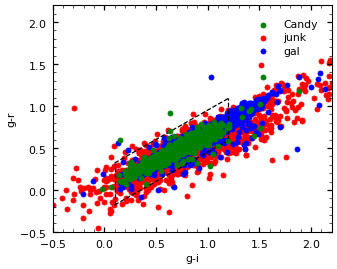

In [233]:
plt.scatter((g_mag - i_mag)[candy], (g_mag - r_mag)[candy], color='g', zorder=10, label='Candy')
plt.scatter((g_mag - i_mag)[junk], (g_mag - r_mag)[junk], color='r', label='junk')
plt.scatter((g_mag - i_mag)[gal], (g_mag - r_mag)[gal], color='b', label='gal')

color_bound = [0.1, 1.2]
half_width = 0.25
plt.vlines(color_bound[0], 0.7 * color_bound[0] - half_width, 
           0.7 * color_bound[0] + half_width, color='k', ls='--')
plt.vlines(color_bound[1], 0.7 * color_bound[1] - half_width, 
           0.7 * color_bound[1] + half_width, color='k', ls='--')

x = np.linspace(color_bound[0], color_bound[1], 100)
plt.plot(x, 0.7 * x - half_width, color='k', ls='--')
plt.plot(x, 0.7 * x + half_width, color='k', ls='--')

plt.xlabel('g-i')
plt.ylabel('g-r')

plt.legend()

plt.xlim(-0.5, 2.2)
plt.ylim(-0.5, 2.2)

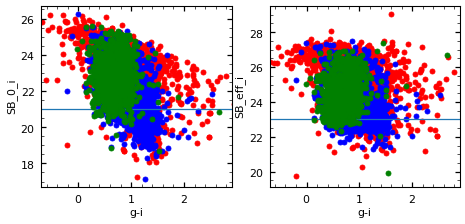

In [234]:
fig, axes = plt.subplots(1, 2, figsize=(9, 4))

plt.sca(axes[0])
plt.scatter((g_mag - i_mag)[candy], meas_cat['SB_0'][:, 2][candy], color='g', zorder=10)
plt.scatter((g_mag - i_mag)[junk], meas_cat['SB_0'][:, 2][junk], color='r')
plt.scatter((g_mag - i_mag)[gal], meas_cat['SB_0'][:, 2][gal], color='b')
plt.xlabel('g-i')
plt.ylabel('SB_0_i')
plt.axhline(21.)
plt.xlim(-0.7, 2.9)

plt.sca(axes[1])
plt.scatter((g_mag - i_mag)[candy], meas_cat['SB_eff_ellip'][:, 1][candy], color='g', zorder=10)
plt.scatter((g_mag - i_mag)[junk], meas_cat['SB_eff_ellip'][:, 1][junk], color='r')
plt.scatter((g_mag - i_mag)[gal], meas_cat['SB_eff_ellip'][:, 1][gal], color='b')
plt.xlabel('g-i')
plt.ylabel('SB_eff_i')
plt.axhline(23.)
plt.xlim(-0.7, 2.9)

plt.subplots_adjust(wspace=0.2)

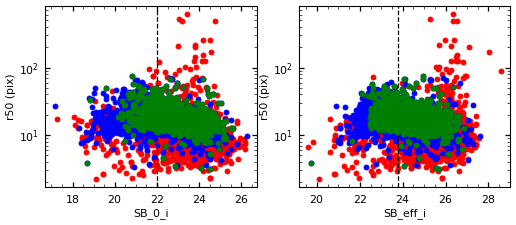

In [236]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(10, 4))
plt.sca(ax1)
plt.scatter(meas_cat['SB_0'][:, 2][candy ], meas_cat['rhalf_ellip'][candy ], color='g', zorder=10)
plt.scatter(meas_cat['SB_0'][:, 2][junk ], meas_cat['rhalf_ellip'][junk ], color='r')
plt.scatter(meas_cat['SB_0'][:, 2][~junk ], meas_cat['rhalf_ellip'][~junk ], color='b')

plt.axvline(22., color='k', ls='--')
plt.yscale('log')
plt.xlabel('SB_0_i')
plt.ylabel('r50 (pix)')

plt.sca(ax2)
plt.scatter(meas_cat['SB_eff_ellip'][:, 2][candy ], meas_cat['rhalf_ellip'][candy], color='g', zorder=10)
plt.scatter(meas_cat['SB_eff_ellip'][:, 2][junk ], meas_cat['rhalf_ellip'][junk], color='r')
plt.scatter(meas_cat['SB_eff_ellip'][:, 2][~junk ], meas_cat['rhalf_ellip'][~junk], color='b')

plt.axvline(23.8, color='k', ls='--')
plt.yscale('log')
plt.xlabel('SB_eff_i')
plt.ylabel('r50 (pix)')


plt.subplots_adjust(wspace=0.2)

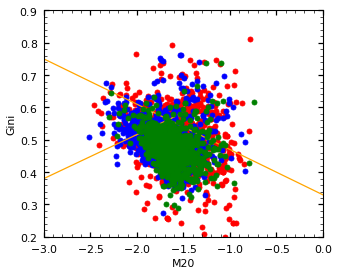

In [237]:
plt.scatter(meas_cat['M20'][candy], meas_cat['Gini'][candy], color='g', zorder=10)
plt.scatter(meas_cat['M20'][junk], meas_cat['Gini'][junk], color='r')
plt.scatter(meas_cat['M20'][gal], meas_cat['Gini'][gal], color='b')

plt.xlabel('M20')
plt.ylabel('Gini')

plt.xlim(-3, 0)
plt.ylim(0.2, 0.9)

x = np.linspace(-3, 0, 10)
plt.plot(x, -0.14 * x + 0.33, color='orange')
x = np.linspace(-3, -1.6, 10)
plt.plot(x, 0.136 * x + 0.788, color='orange')

Text(0, 0.5, 'A')

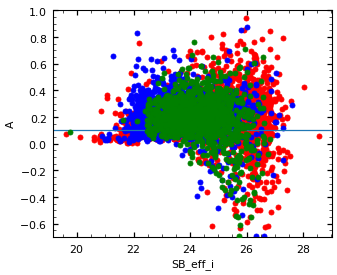

In [238]:
plt.scatter(meas_cat['SB_eff_ellip'][:, 2][candy], meas_cat['A'][candy], color='g', zorder=10)
plt.scatter(meas_cat['SB_eff_ellip'][:, 2][junk], meas_cat['A'][junk], color='r')
plt.scatter(meas_cat['SB_eff_ellip'][:, 2][gal], meas_cat['A'][gal], color='b')
plt.ylim(-.7, 1)
#plt.axvline(3.3)
plt.axhline(0.1)
plt.xlabel('SB_eff_i')
plt.ylabel('A')

Text(0, 0.5, 'A_max')

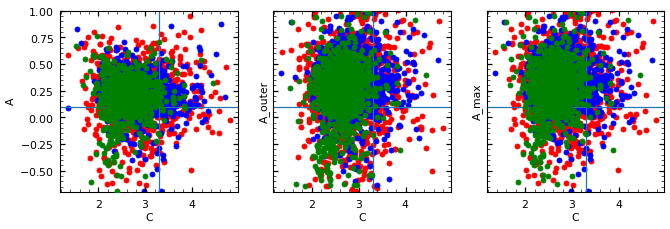

In [239]:
fig, axes = plt.subplots(1, 3, figsize=(13, 4), sharey=True)

plt.sca(axes[0])
plt.scatter(meas_cat['C'][candy], meas_cat['A'][candy], color='g', zorder=10)
plt.scatter(meas_cat['C'][junk], meas_cat['A'][junk], color='r')
plt.scatter(meas_cat['C'][gal], meas_cat['A'][gal], color='b')
plt.ylim(-.7, 1)
plt.axvline(3.3)
plt.axhline(0.1)
plt.xlabel('C')
plt.ylabel('A')

plt.sca(axes[1])
plt.scatter(meas_cat['C'][candy], meas_cat['A_outer'][candy], color='g', zorder=10)
plt.scatter(meas_cat['C'][junk], meas_cat['A_outer'][junk], color='r')
plt.scatter(meas_cat['C'][gal], meas_cat['A_outer'][gal], color='b')
plt.ylim(-.7, 1)
plt.axvline(3.3)
plt.axhline(0.1)
plt.xlabel('C')
plt.ylabel('A_outer')

plt.sca(axes[2])
A_max = np.max([meas_cat['A_outer'], meas_cat['A']], axis=0)
plt.scatter(meas_cat['C'][candy], A_max[candy], color='g', zorder=10)
plt.scatter(meas_cat['C'][junk], A_max[junk], color='r')
plt.scatter(meas_cat['C'][gal], A_max[gal], color='b')
plt.ylim(-.7, 1)
plt.axvline(3.3)
plt.axhline(0.1)
plt.xlabel('C')
plt.ylabel('A_max')

Text(0, 0.5, 'r50')

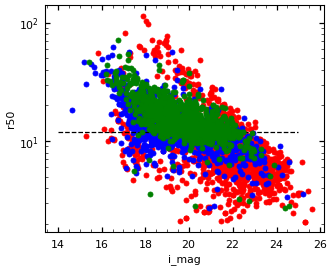

In [242]:
plt.scatter(i_mag[candy], meas_cat['r50'][candy], color='g', zorder=10)
plt.scatter(i_mag[junk], meas_cat['r50'][junk], color='r')
plt.scatter(i_mag[gal], meas_cat['r50'][gal], color='b')

#plt.ylim(0, 1)
plt.hlines(2 / 0.168, 14, 25, color='k', ls='--')
plt.yscale('log')
plt.xlabel('i_mag')
plt.ylabel('r50')

Text(0, 0.5, 'r50')

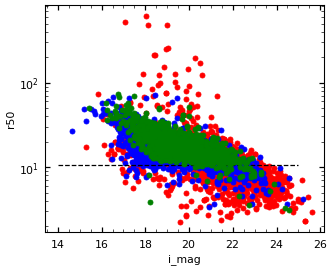

In [240]:
plt.scatter(i_mag[candy], meas_cat['rhalf_ellip'][candy], color='g', zorder=10)
plt.scatter(i_mag[junk], meas_cat['rhalf_ellip'][junk], color='r')
plt.scatter(i_mag[gal], meas_cat['rhalf_ellip'][gal], color='b')

#plt.ylim(0, 1)
plt.hlines(1.8 / 0.168, 14, 25, color='k', ls='--')
plt.yscale('log')
plt.xlabel('i_mag')
plt.ylabel('r50')

(-0.6, 2.5)

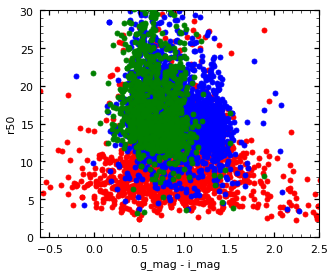

In [62]:
plt.scatter((g_mag - i_mag)[candy], meas_cat['rhalf_ellip'][candy], color='g', zorder=10)
plt.scatter((g_mag - i_mag)[junk], meas_cat['rhalf_ellip'][junk], color='r')
plt.scatter((g_mag - i_mag)[gal], meas_cat['rhalf_ellip'][gal], color='b')

#plt.ylim(0, 1)
#plt.yscale('log')
plt.xlabel('g_mag - i_mag')
plt.ylabel('r50')

plt.ylim(0, 30)
plt.xlim(-0.6, 2.5)

In [99]:
np.where(lsbg_cat['viz-id'] == 58474)

(array([327]),)

(0.0, 30.0)

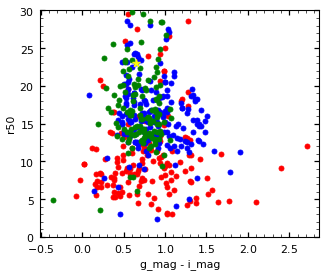

In [100]:
plt.scatter((g_mag - i_mag)[candy], meas_cat['rhalf_ellip'][candy], color='g', zorder=10)
plt.scatter((g_mag - i_mag)[junk], meas_cat['rhalf_ellip'][junk], color='r')
plt.scatter((g_mag - i_mag)[gal], meas_cat['rhalf_ellip'][gal], color='b')
plt.scatter((g_mag - i_mag)[327], meas_cat['rhalf_ellip'][327], color='yellow', marker='*', s=100, label='gal', zorder=10)

#plt.ylim(0, 1)
#plt.yscale('log')
plt.xlabel('g_mag - i_mag')
plt.ylabel('r50')

plt.ylim(0, 30)

In [63]:
print('Candy:', np.sum(candy))
print('Gal:', np.sum(gal))
print('Junk:', np.sum(junk))

Candy: 1251
Gal: 2360
Junk: 1865


In [282]:
color_bound = [0.1, 1.2]
half_width = 0.25

mask = (g_mag - i_mag < color_bound[1]) & (g_mag - i_mag > color_bound[0]) & (
    (g_mag - r_mag) > 0.7 * (g_mag - i_mag) - half_width) & (
    (g_mag - r_mag) < 0.7 * (g_mag - i_mag) + half_width) & (i_mag < 22.5)

mask &= (meas_cat['r50'] > 2 / 0.168) & (meas_cat['rhalf_ellip'] < 12 / 0.168) & (meas_cat['r20'] > 1 / 0.168)
#mask &= (meas_cat['rhalf_ellip'] > 1.8 / 0.168) & (meas_cat['rhalf_ellip'] < 12 / 0.168)

mask &= (meas_cat['SB_0'][:, 2] > 21)

#mask &= (meas_cat['SB_eff_ellip'][:, 2] > 23.) # Cuts based on JG votes
mask &= (meas_cat['SB_eff_ellip'][:, 2] > 23.) # Cuts based on JG votes

mask &= (meas_cat['M20'] < -1.1)
mask &= (meas_cat['Gini'] < 0.7)
mask &= ~((meas_cat['M20'] < -1.6) & (
    meas_cat['Gini'] > meas_cat['M20'] * 0.136 + 0.788) & (meas_cat['Gini'] < meas_cat['M20'] * -0.136 + 0.33))

mask &= (meas_cat['C'] < 3.5)
#mask &= (meas_cat['A_outer'] <= 0.13)


print('Candy:', np.sum(mask & candy))
print('Gal:', np.sum(mask & gal))
print('Junk:', np.sum(mask & junk))

Candy: 754
Gal: 640
Junk: 113


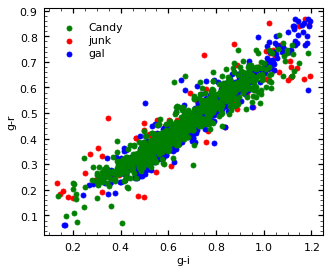

In [283]:
plt.scatter((g_mag - i_mag)[candy & mask], (g_mag - r_mag)[candy & mask], color='g', zorder=10, label='Candy')
plt.scatter((g_mag - i_mag)[junk & mask], (g_mag - r_mag)[junk & mask], color='r', label='junk')
plt.scatter((g_mag - i_mag)[gal & mask], (g_mag - r_mag)[gal & mask], color='b', label='gal')

plt.xlabel('g-i')
plt.ylabel('g-r')

plt.legend()

#plt.xlim(-0.5, 2.2)
#plt.ylim(-0.5, 2.2)

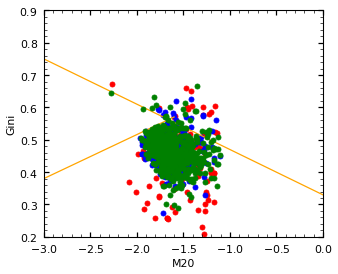

In [284]:
plt.scatter(meas_cat['M20'][candy & mask], meas_cat['Gini'][candy & mask], color='g', zorder=10)
plt.scatter(meas_cat['M20'][junk & mask], meas_cat['Gini'][junk & mask], color='r')
plt.scatter(meas_cat['M20'][gal & mask], meas_cat['Gini'][gal & mask], color='b')

plt.xlabel('M20')
plt.ylabel('Gini')

plt.xlim(-3, 0)
plt.ylim(0.2, 0.9)

x = np.linspace(-3, 0, 10)
plt.plot(x, -0.14 * x + 0.33, color='orange')
x = np.linspace(-3, -1.6, 10)
plt.plot(x, 0.136 * x + 0.788, color='orange')

Text(0, 0.5, 'r50')

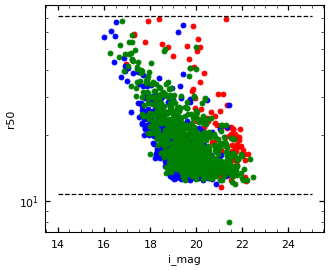

In [290]:
plt.scatter(i_mag[candy & mask], meas_cat['rhalf_ellip'][candy & mask], color='g', zorder=10)
plt.scatter(i_mag[junk & mask], meas_cat['rhalf_ellip'][junk & mask], color='r')
plt.scatter(i_mag[gal & mask], meas_cat['rhalf_ellip'][gal & mask], color='b')

#plt.ylim(0, 1)
plt.hlines(1.8 / 0.168, 14, 25, color='k', ls='--')
plt.hlines(12 / 0.168, 14, 25, color='k', ls='--')
plt.yscale('log')
plt.xlabel('i_mag')
plt.ylabel('r50')

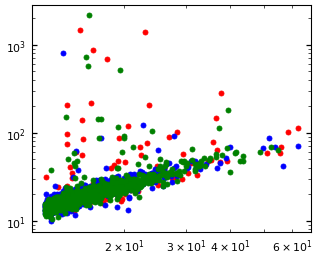

In [291]:
plt.scatter(meas_cat['r50'][candy & mask], meas_cat['sersic_rhalf'][candy & mask], color='g', zorder=10)
plt.scatter(meas_cat['r50'][junk & mask], meas_cat['sersic_rhalf'][junk & mask], color='r',)
plt.scatter(meas_cat['r50'][gal & mask], meas_cat['sersic_rhalf'][gal & mask], color='b')
plt.xscale('log')
plt.yscale('log')

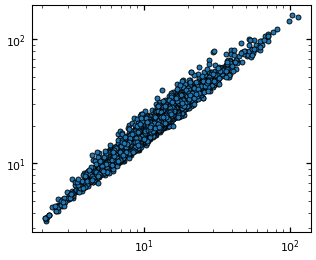

In [252]:
plt.scatter(meas_cat['r50'], meas_cat['r80'])
plt.xscale('log')
plt.yscale('log')

Text(0, 0.5, 'r50')

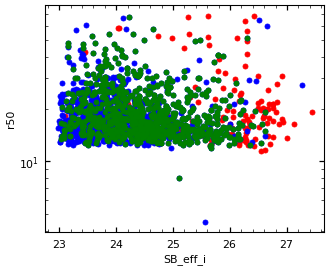

In [253]:
plt.scatter(meas_cat['SB_eff_circ'][:, 2][candy & mask], meas_cat['rhalf_ellip'][candy & mask], color='g', zorder=10)
plt.scatter(meas_cat['SB_eff_circ'][:, 2][junk & mask], meas_cat['rhalf_ellip'][junk & mask], color='r')
plt.scatter(meas_cat['SB_eff_circ'][:, 2][~junk & mask], meas_cat['rhalf_ellip'][~junk & mask], color='b')

#plt.ylim(0, 1)
plt.yscale('log')
plt.xlabel('SB_eff_i')
plt.ylabel('r50')

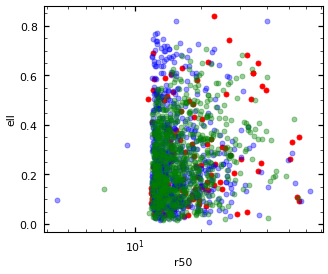

In [254]:
plt.scatter(meas_cat['rhalf_circ'][candy & mask], meas_cat['ell_sym'][candy & mask], color='g', zorder=10, alpha=.4)
plt.scatter(meas_cat['rhalf_circ'][junk & mask], meas_cat['ell_sym'][junk & mask], color='r')
plt.scatter(meas_cat['rhalf_circ'][gal & mask], meas_cat['ell_sym'][gal & mask], color='b', alpha=0.4)

# plt.xscale('log')
# plt.yscale('log')
#plt.xlim(-5, 100)
#plt.ylim(-5, 100)

plt.xlabel('r50')
plt.ylabel('ell')
plt.xscale('log')
#plt.yscale('log')

### Save catalog

In [255]:
# lsbg_cat['host_RA'] = Table.read('./Catalog/NSA/z002_004/lsbg_NSA_MW_z002_004.fits')[100:]['host_RA']
# lsbg_cat['host_DEC'] = Table.read('./Catalog/NSA/z002_004/lsbg_NSA_MW_z002_004.fits')[100:]['host_DEC']

In [256]:
from astropy.table import hstack
hstack([lsbg_cat[mask], meas_cat[mask]]
      ).write('./Catalog/NSA/z002_004/lsbg_NSA_MW_z002_004_after_cuts_JG.fits', overwrite=True)

In [257]:
cuts_cat = Table.read('./Catalog/NSA/z002_004/lsbg_NSA_MW_z002_004_after_cuts_JG.fits')

In [258]:
from astropy.coordinates import SkyCoord

Text(0.5, 0, '$d_{ang} / R_{vir, ang}$')

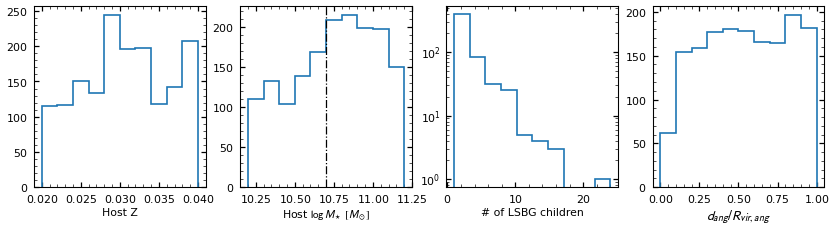

In [259]:
fig, axes = plt.subplots(1, 4, figsize=(17, 4))

plt.sca(axes[0])
plt.hist(cuts_cat['host_z'], range=[0.02, 0.04], 
         bins=10, histtype='step', lw=2);
plt.xlabel('Host Z')

plt.sca(axes[1])
plt.hist(cuts_cat['host_stellar_mass'], range=[10.2, 11.2], 
         bins=10, histtype='step', lw=2);
plt.xlabel(r'Host $\log\, M_\star\ [M_\odot]$')
plt.axvline(10.7, c='k', ls='-.')
plt.subplots_adjust(wspace=0.2)

plt.sca(axes[2])
uniques, counts = np.unique(cuts_cat['host_name'], return_counts=True)
plt.hist(counts, histtype='step', lw=2)
plt.yscale('log')
plt.xlabel('# of LSBG children')

plt.sca(axes[3])
lsbg_coord = SkyCoord(cuts_cat['ra'], cuts_cat['dec'], unit='deg')
host_coord = SkyCoord(cuts_cat['host_RA'], cuts_cat['host_DEC'], unit='deg')
dist = lsbg_coord.separation(host_coord)
plt.hist(dist.to(u.deg).value / cuts_cat['host_r_vir_ang'].data, 
         range=[0, 1.], bins=10, histtype='step', lw=2);
plt.xlabel(r'$d_{ang} / R_{vir, ang}$', fontsize=17)

In [260]:
ang_diam_dist = cuts_cat['host_ang_diam_dist'] # not consider peculiar motion

rhalf_phys = cuts_cat['rhalf_circ'] * kz.HSC_pixel_scale / 206265 * ang_diam_dist * 1000 # kpc
cuts_cat['rhalf_circ_phys'] = rhalf_phys

rhalf_phys = cuts_cat['rhalf_ellip'] * kz.HSC_pixel_scale / 206265 * ang_diam_dist * 1000 # kpc
cuts_cat['rhalf_ellip_phys'] = rhalf_phys

In [261]:
cuts_cat['abs_mag'] = cuts_cat['mag'] - 25 - 5 * np.log10(ang_diam_dist)[:, np.newaxis] # ugri
BV = 0.62 * (cuts_cat['mag'][:, 0] - cuts_cat['mag'][:, 1]) + 0.15
V = cuts_cat['mag'][:, 0] - 0.52 * (cuts_cat['mag'][:, 0] - cuts_cat['mag'][:, 1]) - 0.03
V_abs = V - 25 - 5 * np.log10(ang_diam_dist)
log_ML_V = 1.493 * BV - 0.681
M = (4.83 - V_abs) / (2.5) + log_ML_V
cuts_cat['log_m_star'] = M

In [262]:
### UDGs
flag = (cuts_cat['rhalf_ellip_phys'] > 1.5) & (cuts_cat['SB_0'][:, 0] >= 24) & (cuts_cat['sersic_ell'] < 0.7)
print('# of UDGs:', np.sum(flag))

# of UDGs: 254


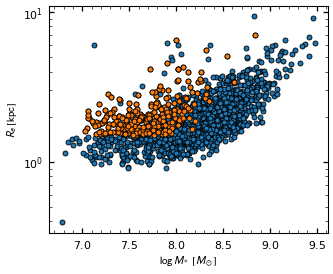

In [263]:
plt.scatter(cuts_cat['log_m_star'], cuts_cat['rhalf_ellip_phys'])
plt.scatter(cuts_cat['log_m_star'][flag], cuts_cat['rhalf_ellip_phys'][flag])

plt.xlabel(r'$\log\, M_*\ [M_\odot]$')
plt.ylabel(r'$R_e\ [\rm kpc]$')

plt.yscale('log')

Text(0.5, 0, '$d_{ang} / R_{vir, ang}$')

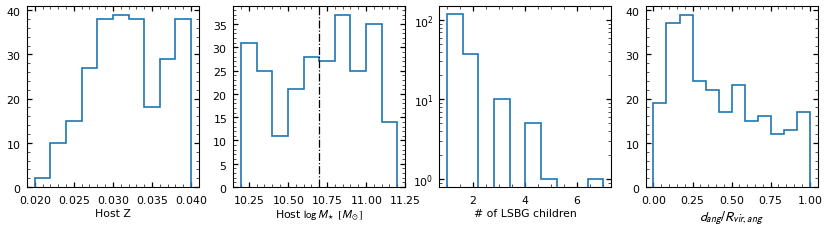

In [264]:
fig, axes = plt.subplots(1, 4, figsize=(17, 4))

plt.sca(axes[0])
plt.hist(cuts_cat[flag]['host_z'], range=[0.02, 0.04], 
         bins=10, histtype='step', lw=2);
plt.xlabel('Host Z')

plt.sca(axes[1])
plt.hist(cuts_cat[flag]['host_stellar_mass'], range=[10.2, 11.2], 
         bins=10, histtype='step', lw=2);
plt.xlabel(r'Host $\log\, M_\star\ [M_\odot]$')
plt.axvline(10.7, c='k', ls='-.')
plt.subplots_adjust(wspace=0.2)

plt.sca(axes[2])
uniques, counts = np.unique(cuts_cat[flag]['host_name'], return_counts=True)
plt.hist(counts, histtype='step', lw=2)
plt.yscale('log')
plt.xlabel('# of LSBG children')

plt.sca(axes[3])
lsbg_coord = SkyCoord(cuts_cat[flag]['ra'], cuts_cat[flag]['dec'], unit='deg')
host_coord = SkyCoord(cuts_cat[flag]['host_RA'], cuts_cat[flag]['host_DEC'], unit='deg')
dist = lsbg_coord.separation(host_coord)
plt.hist(dist.to(u.deg).value / cuts_cat[flag]['host_r_vir_ang'].data, 
         range=[0, 1.], bins=12, histtype='step', lw=2);
plt.xlabel(r'$d_{ang} / R_{vir, ang}$', fontsize=17)

(array([148.,  65.,  21.,   9.,   6.,   2.,   1.,   0.,   0.,   2.]),
 array([2.008617  , 2.78970999, 3.57080299, 4.35189599, 5.13298898,
        5.91408198, 6.69517498, 7.47626797, 8.25736097, 9.03845396,
        9.81954696]),
 <BarContainer object of 10 artists>)

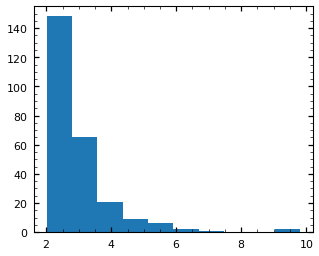

In [265]:
plt.hist(cuts_cat[flag]['r50'] * 0.168)

In [298]:
cuts_cat[cuts_cat['viz-id'] == 35220][['ra', 'dec']]

ra,dec
float64,float64
34.5144192,-4.3059998


In [220]:
cuts_cat[cuts_cat['viz-id'] == 52367][['host_RA', 'host_DEC']]

host_RA,host_DEC
float64,float64
188.27518365318946,0.7783466002094354


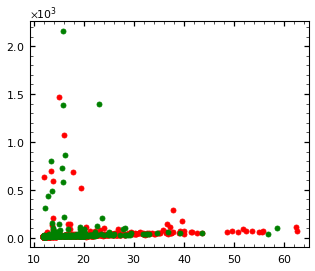

In [293]:
plt.scatter(cuts_cat['r50'][flag], cuts_cat['sersic_rhalf'][flag], color='g', zorder=10)
plt.scatter(cuts_cat['r50'][~flag], cuts_cat['sersic_rhalf'][~flag], color='r', )



In [295]:
cuts_cat[flag][cuts_cat['sersic_rhalf'][flag] > 200]['viz-id']

3256
9588
23552
23950
31162
35220
40862
40955
49557
54383
75217


In [267]:
cuts_cat[flag].write('./Catalog/NSA/z002_004/UDG_NSA_MW_z002_004_JG.fits', overwrite=True)